[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds-reboot/python-first-part/blob/main/notebooks/hometasks/Task3_dmrf_OOP.ipynb)

# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.



## Список классов
### Class  RealtyBase - класс формирования базы объектов
### Class  Transform - класс приведения базы объектов к виду позволяющему анализ
### Class  Analyze - класс визуализации и анализа

In [57]:
class RealtyBase:
    ''' Класс скачивает базу объектов, сохраняет в текущую папку , либо по переданному пути path в заданном
    формате '''
    def __init__(self, cnt=1 , path ='./' , type='pickle'):
        self._path = path
        self._type = type
        self.data = []
        self._offset = 0
        self._cnt = cnt

    def get_data (self):
        import pandas as pd
        import requests
        #начальное смещение
        offset_ = self._offset

        #кол-во записей для загрузки за один запрос
        limit_ = 10

        res = []
        cnt = 0

        #загружаем частями все id объектов и формируем результирующий список
        while cnt <= self._cnt: 
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
            temp = requests.get(url).json().get('data').get('list')
            cnt += len(temp)
    
            if len(temp) :        
                objids = [x.get('objId') for x in temp]
                res += objids
                offset_ += limit_
            else:
                print('loaded : ' + str(offset_) + ' records')
                break

        #Загрузка данных по списку объектов

        objlist = []
        for el in res:
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{el}'
            x = requests.get(url).json().get('data')
            objlist.append(x)


        df = pd.concat([ pd.json_normalize(i) for i in objlist], ignore_index=True)
        self.data = df
        print('Data loaded')

    def save_data (self, *type: str):
        if type:
            self._type = type
        if self._type == 'excel':
            self.data.to_excel(self._path + 'house_data.xlsx')
            print('Saved to ' + self._type)
        elif self._type =='pickle':
            #выгрузим в pickle
            self.data.to_pickle(self._path + './house_data.pkl')
            print('Saved to ' + self._type)
        elif self._type =='db':
            #выгрузим в БД
            import sqlite3

            #создаем базу
            conn = sqlite3.connect( self._path + 'sample.db')
            #выгружаем данные в таблицу house_data
            self.data.to_sql('house_data', conn , if_exists='replace')
            print('Saved to ' + self._type)

            conn.commit()
            conn.close()
        else:
            raise ValueError ('No such type defined')      

In [135]:
class Transform:
    def __init__(self, path):
        self._path =  path

    def load(self):
        import pandas as pd
        self._obj = pd.read_pickle(self._path)

    def get_columns(self):
        print( self._obj.columns )

    def set_types(self):
        import pandas as pd
        #  выберем колонки по которым будем проводить исследование
        col_for_analize = ['region',
                    'objElemLivingCnt', 
                    'objReady100PercDt', 
                    'objElemParkingCnt',
                    'objSquareLiving', 
                    'objFlatCnt', 
                    'objFlatSq', 
                    'objFloorCnt', 
                    'soldOutPerc',
                    'objPriceAvg',
                    ]
        df = pd.DataFrame(self._obj[col_for_analize])
        df.fillna(0, inplace = True)

        # приведем типы колонок к единому формату .  для даты 100 процентой готовности укадем дату
        col_types = {'region' : 'int32' ,
             'objElemLivingCnt' : 'int32' ,
             'objReady100PercDt' : 'datetime64', 
             'objElemParkingCnt' : 'int32',
             'objSquareLiving' : 'float64', 
             'objFlatCnt' : 'int32', 
             'objFlatSq' : 'float64', 
             'objFloorCnt' : 'int32', 
             'soldOutPerc' : 'float64',
             'objPriceAvg' : 'float64'
             }
        
        df = df.astype(col_types)
        df['ready_year'] = df['objReady100PercDt'].apply( lambda x : x.year)
        df['avg_sqr'] = df['objFlatSq'] / df['objFlatCnt']
             
        self._obj = df
    
    def get_result(self):
        return (self._obj)


In [ ]:
class Analyze:

    def __init__( self, obj, by = 'region'):
        self._by = 'region'
        self._obj = obj

    def show_graph(self, by):
        import matplotlib.pyplot as plt
        df = self._obj
        df = df[df['objPriceAvg'] > 0]
        df['objProce'] = df['objPriceAvg'] * df['objFlatSq']

        if by:
            self._by = by
        
        if by == 'region' :
            # средняя цена по регионам.
            df1 = df[['region','objFlatSq','objProce']].groupby(['region']).aggregate({'objFlatSq' : 'sum', 'objProce' : 'sum'})
            
            plt.rcParams.update({'figure.autolayout': True})
            fig , ax = plt.subplots(figsize = (8,12))

            for_bar = (df1['objProce'] / df1['objFlatSq'])

            cat = [ str(x) for x in for_bar.index ]

            plt.barh( cat , for_bar.values , height=0.3 )
            plt.show()

        elif by == 'year':
            
            # ввод жилья по годам .
            by_year = df[['ready_year','objSquareLiving']].groupby(['ready_year']).agg('sum')
            
            plt.rcParams.update({'figure.autolayout': True})
            fig , ax = plt.subplots(figsize = (8,12))

            x_ticks = [ str(x) for x in by_year.index ]
            plt.bar(x_ticks, by_year['objSquareLiving'])


            plt.show()
        
        else:
            raise ValueError ('No such graph analytics implemented yet')


In [147]:
rb = RealtyBase(10,'./','excel')

In [148]:
rb.get_data()

Data loaded


In [149]:
tr = Transform(path='house_data.pkl')

In [150]:
tr.load()

In [151]:
tr.set_types()

In [152]:
df = tr.get_result()

In [153]:
analys = Analyze(df)

/tmp/ipykernel_166496/1940015464.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['objProce'] = df['objPriceAvg'] * df['objFlatSq']


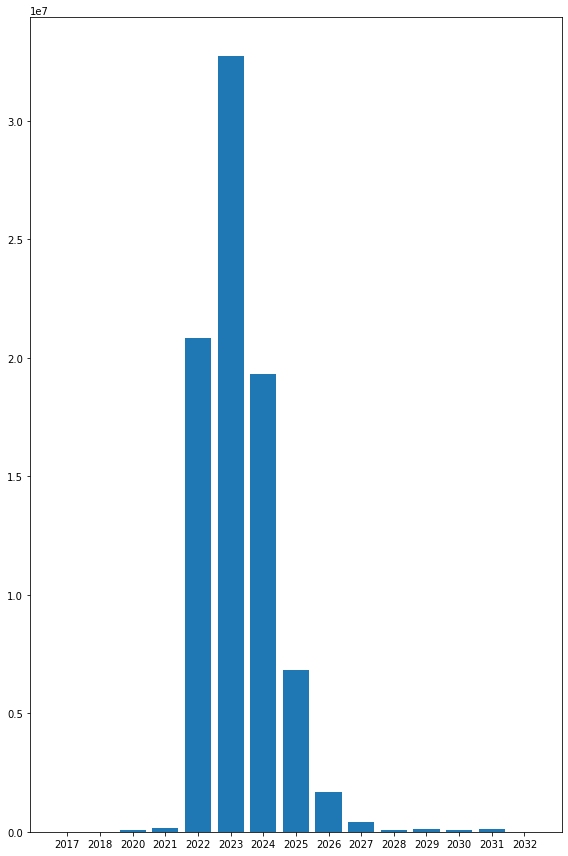

In [154]:
analys.show_graph('year')